In [1]:
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt

In [563]:
# img_name='img1.jpg'
img_name='im2.jpg'
# img_name='img3.jpg'
# img_name='img4.jpg'

In [564]:
def bgr2rgbmerged(img):
    b,g,r =cv2.split(img)
    return cv2.merge([r,g,b])

In [565]:
def bgr2rgb(img):
    b,g,r =cv2.split(img)
    return [r,g,b]

In [566]:
def min_max(img):
    img=img.astype(np.float32)

    matrix=img
    percentile = np.percentile(img, 1)
    matrix[matrix < percentile] = np.inf
    min_val = np.amin(matrix)

    matrix=img
    percentile = np.percentile(img, 98.7)
    matrix[matrix > percentile] = 0
    max_val = np.amax(matrix)

    return min_val,max_val

In [567]:
[r,g,b]= bgr2rgb(cv2.imread(img_name))
r_min,r_max=min_max(r)
g_min,g_max=min_max(g)
b_min,b_max=min_max(b)
print(r_min,r_max,g_min,g_max,b_min,b_max)

21.0 125.0 103.0 246.0 21.0 109.0


# Attenuation map guided color correction

In [568]:
Ir_CR=255*(r-r_min)/(r_max-r_min)
Ig_CR=255*(g-g_min)/(g_max-g_min)
Ib_CR=255*(b-b_min)/(b_max-b_min)

2


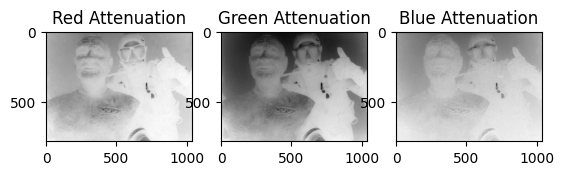

In [569]:
gamma=1.2
Mr=1-((r/255.0)**gamma)
Mg=1-((g/255.0)**gamma)
Mb=1-((b/255.0)**gamma)

c_star=np.argmax([np.mean(Mr),np.mean(Mg),np.mean(Mb)])
print(c_star)


plt.subplot(1,3, 1)
plt.imshow(Mr, cmap="gray")
plt.title('Red Attenuation')
plt.subplot(1,3, 2)
plt.imshow(Mg, cmap="gray")
plt.title('Green Attenuation')
plt.subplot(1,3, 3)
plt.imshow(Mb, cmap="gray")
# plt.imshow(cv2.cvtColor(J, cv2.COLOR_BGR2RGB))
plt.title('Blue Attenuation')

plt.show()

In [571]:
wr=1
wg=1
wb=1
if img_name=="img3.jpg":
    wr=0.8
    wb=0.8
elif img_name=="im2.jpg":
    wg=0.3
else:
    wg=0.9
    wb=0.9

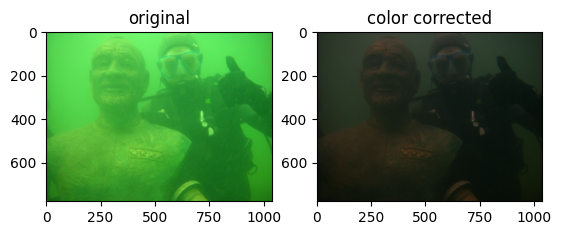

In [573]:
t_r = np.exp(-Mr)
t_g = np.exp(-Mg)
t_b = np.exp(-Mb)

img= bgr2rgbmerged(cv2.imread(img_name))

corrected_img = np.zeros_like(img)
corrected_img[:,:,0] = img[:,:,0] * t_r*wr
corrected_img[:,:,1] = img[:,:,1] * t_g*wg
corrected_img[:,:,2] = img[:,:,2] * t_b*wb

# Display the corrected image

plt.subplot(1,2, 1)
plt.imshow(img)
plt.title('original')

plt.subplot(1,2, 2)
plt.imshow(corrected_img)
plt.title('color corrected')

plt.show()

# Transmission estimation based on maximum attenuation identification

C:\Users\Admin\AppData\Local\Temp\ipykernel_6240\3730182310.py:21: RuntimeWarning: overflow encountered in ubyte_scalars
  D = max_b - np.max([max_g, max_r])


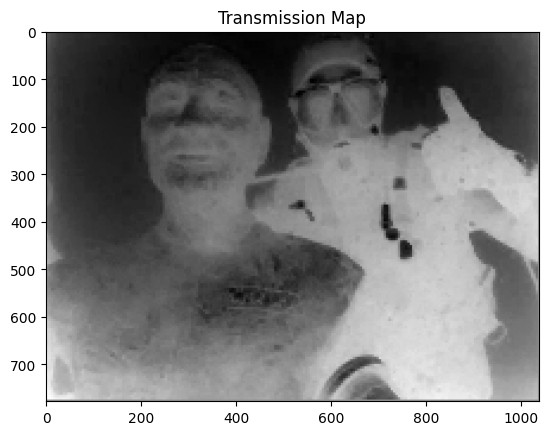

In [575]:
h, w = r.shape[:2]
patch_size = 5
# Define the depth map as an array of zeros
depth_map = np.zeros((h, w))
trans_map=  np.zeros((h, w))
# Loop over all patches
for i in range(0, h - patch_size, patch_size):
    for j in range(0, w - patch_size, patch_size):
        # Calculate the maximum intensity of the red, green and blue channels
        max_r = np.max(r[i:i+patch_size, j:j+patch_size])
        max_g = np.max(g[i:i+patch_size, j:j+patch_size])
        max_b = np.max(b[i:i+patch_size, j:j+patch_size])
        
        maxD=np.max([max_b,max_g,max_r])
        # Calculate the difference between the maximum intensity of the max attenuated and that of the other two channels
        if(c_star==0):
            D = max_r - np.max([max_g, max_b])
        elif(c_star==1):
            D = max_g - np.max([max_r, max_b])
        elif(c_star==2):
            D = max_b - np.max([max_g, max_r])

        
        
        # Update the depth map with the calculated value
        depth_map[i:i+patch_size, j:j+patch_size] = D
        trans_map[i:i+patch_size, j:j+patch_size] = D+(1-maxD)

plt.imshow(trans_map, cmap="gray")
plt.title("Transmission Map")
plt.show()

In [579]:
from skimage.color import rgb2lab
from skimage.filters import median

In [582]:
def laplacian_pyramid_decomposition(image, levels):
    pyramid = []
    for i in range(levels):
        blurred = cv2.GaussianBlur(image, (5, 5), 0)
        pyramid.append(image - blurred)
        image = cv2.pyrDown(blurred)
    pyramid.append(image)
    return pyramid[::-1]


# Image dehazing via multi-scale edge-preserving decomposition

(195, 260)
(389, 519)
(778, 1037)


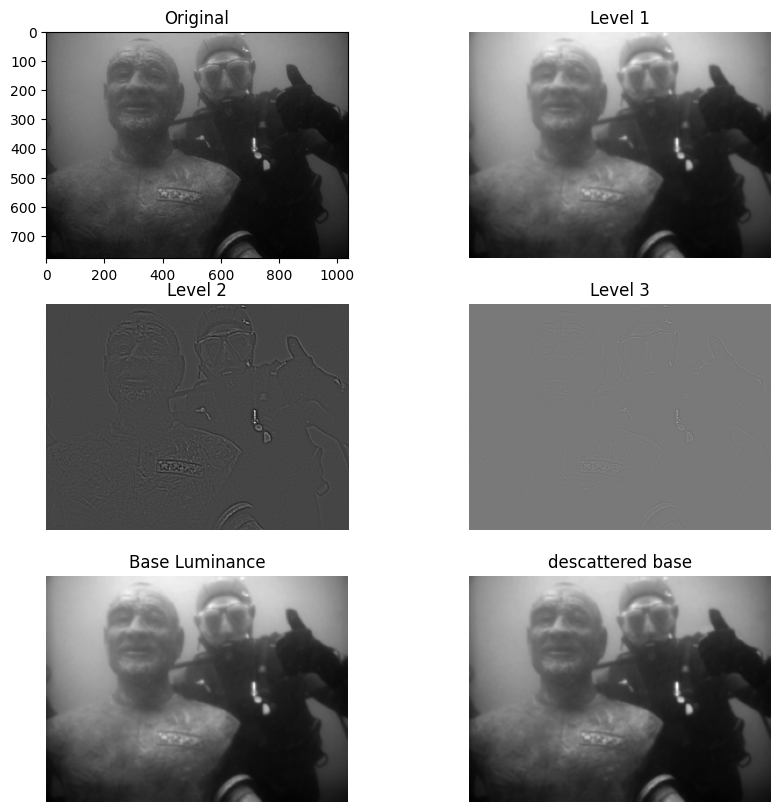

In [583]:
img_lab = rgb2lab(corrected_img)

# Define parameters
k = 3
sv = 41
epsilon = 0.2
L = img_lab[:, :, 0]
pyramid = laplacian_pyramid_decomposition(L, 2)

# Display the base layer and detail layers
plt.figure(figsize=(10,10))
plt.subplot(3, 2, 1)
plt.imshow(L, cmap='gray')
plt.title('Original')

for i in range(len(pyramid)):
    plt.subplot(3, 2, i+2)
    plt.imshow(pyramid[i], cmap='gray')
    print(pyramid[i].shape)
    plt.title('Level {}'.format(i+1))
    plt.axis('off')

base=pyramid[0]
A= median(base, footprint=np.ones((sv, sv)))
B= A- median(base-A, footprint=np.ones((sv, sv)))
B[B < 0] = 0

L2 = np.maximum(np.minimum(B, base), 0)
b_descat = base - ( L2 * epsilon)

plt.subplot(3,2, 5)
plt.imshow(base,cmap='gray')
plt.title('Base Luminance')
plt.axis('off')

plt.subplot(3,2, 6)
plt.imshow(b_descat,cmap='gray')
plt.title('descattered base')
plt.axis('off')

plt.show()

(778, 1037)
(778, 1037, 3)


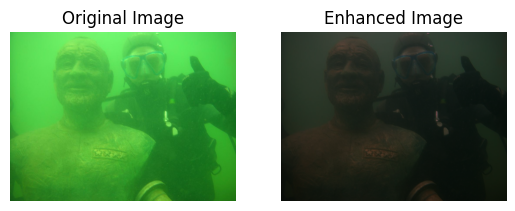

In [585]:
from skimage.color import rgb2lab, lab2rgb
def S(row, d):
    s=1/(1+np.exp(-row*d))
    return s

d1=pyramid[1]
d2=pyramid[2]
b_descat=np.resize(b_descat, img_lab[:,:,0].shape)
d1= np.resize(d1, img_lab[:,:,0].shape)
d2= np.resize(d2,  img_lab[:,:,0].shape)
print(d1.shape)

# L_final=b_descat+S(1,d1)+S(1,d2)
L_final=img_lab[:,:,0]
print(img_lab.shape)
modified_lab_img = np.zeros_like(img_lab)
modified_lab_img[:,:,0], modified_lab_img[:,:,1], modified_lab_img[:,:,2] = L_final,img_lab[:,:,1]*0.9 ,img_lab[:,:,2]*0.8

modified_rgb_img = lab2rgb(modified_lab_img)

# Display the modified RGB image
plt.subplot(1,2, 1)
plt.imshow(img)
plt.title('Original Image')
plt.axis('off')

plt.subplot(1,2, 2)
plt.imshow(modified_rgb_img)
plt.title('Enhanced Image')
plt.axis('off')

plt.show()